**Statistical Learning Lab** <br>
**Assignment - 8** <br>
**Recurrent Neural Network for Stock Prediction** <br>
Name: Semanti Ghosh <br>

Roll No.: 22IM10036


1.	Choose a stock of your choice from NIFTY 50 list from Yahoo Finance.

2.	Take last 5 years stock price data of the selected stock.

3.	Create test dataset for past 3 months, and training set from 5 years to the date before 3 months.

4.	Use a predictive model using 3 LSTM layers, with past 60 days data, ntimestep = 60, dropout regularization ndrop = 0.2.

5.	Create the plots comparing observed value of the test data and the predictive value.

6.	Use grid search to optimize hyperparameters such as ndrop , ntimestep and batch size. Compare test result with previous findings.

Give the result and the code in a single pdf document along with plots.


In [ ]:
pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 97.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 w

In [26]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
#from keras.models import Sequential
#from keras.layers import LSTM, Dense, Dropout
#from keras.optimizers import Adam
from sklearn.model_selection import ParameterGrid

Chosen Stock is **TCS** on Nifty (NSE)


1.   Download from Yahoo Finance
2.   Get the Train & Test Data


In [32]:
# Section 1: Fetch Data and Create Train-Test Split
# Define the stock ticker for TCS on NSE
ticker = "TCS.NS"

# Define end date (today)
end_date = datetime.today().strftime('%Y-%m-%d')

# Fetch more than 5 years to ensure we get full 90 trading days in test set
start_date = (datetime.today() - timedelta(days=5*365 + 30)).strftime('%Y-%m-%d')

# Download stock data
df = yf.download(ticker, start=start_date, end=end_date)

# Ensure data was fetched
if df.empty:
    print(f"Failed to fetch data for {ticker}. Please check the ticker symbol or try again later.")
else:
    print(f"Total data points: {len(df)}")

# Adjust test_start_date to ensure 90 **trading days**
test_dates = df.index[-90:]  # Last 90 actual trading days
test_start_date = test_dates[0]  # First date of test set

# Split into train and test sets
train_data = df.loc[:test_start_date, ['Close']].copy()
test_data = df.loc[test_start_date:, ['Close']].copy()

print(f"Training Data Size: {train_data.shape}")
print(f"Testing Data Size: {test_data.shape}")

[*********************100%***********************]  1 of 1 completed

Total data points: 1258
Training Data Size: (1169, 1)
Testing Data Size: (90, 1)




1.   Perform scaling using MinMaxScalar
2.   Put n_steps to 30 so that we can get at least 60 test data, from the given ntimestep = 60
3.   The first n_steps (30 days) are used as input for the first prediction. This process continues, sliding forward by 1 day each time. As a result, the last n_steps samples cannot be used as independent targets, reducing the effective dataset size by n_steps.



In [33]:
from sklearn.preprocessing import MinMaxScaler

# Normalize price data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data[['Close']])
test_scaled = scaler.transform(test_data[['Close']])

# Function to create sequences for LSTM
def create_sequences_with_dates(data, dates, n_steps):
    X, y, y_dates = [], [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
        y_dates.append(dates[i + n_steps])  # Capture correct date
    return np.array(X), np.array(y), np.array(y_dates, dtype="datetime64[D]")  # Ensure daily timestamps

n_steps = 30  # Reduce from 60 to 30 to get enough test samples

# Create sequences for LSTM
X_train, y_train, _ = create_sequences_with_dates(train_scaled, train_data.index, n_steps)
X_test, y_test, test_dates = create_sequences_with_dates(test_scaled, test_data.index, n_steps)

print(f"Final Training Samples: {X_train.shape[0]}")
print(f"Final Test Samples: {X_test.shape[0]}")  # Should be ~60 test points


Final Training Samples: 1139
Final Test Samples: 60


**Create the predictive model using 3 LSTM layers**

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(n_steps, ndrop):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(n_steps, 1)),
        Dropout(ndrop),
        LSTM(50, return_sequences=True),
        Dropout(ndrop),
        LSTM(50),
        Dropout(ndrop),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

model = build_model(n_steps, 0.2)

# Reshape X_train for LSTM input format
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0789
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0081
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0051
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0055
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0048
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0052
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0045
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0042
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0046
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0038
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0044
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0042
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0040
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0034
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0048
Epoch 16/50
36/

**Plots comparing observed value of the test data and the predictive value.**

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 450ms/step


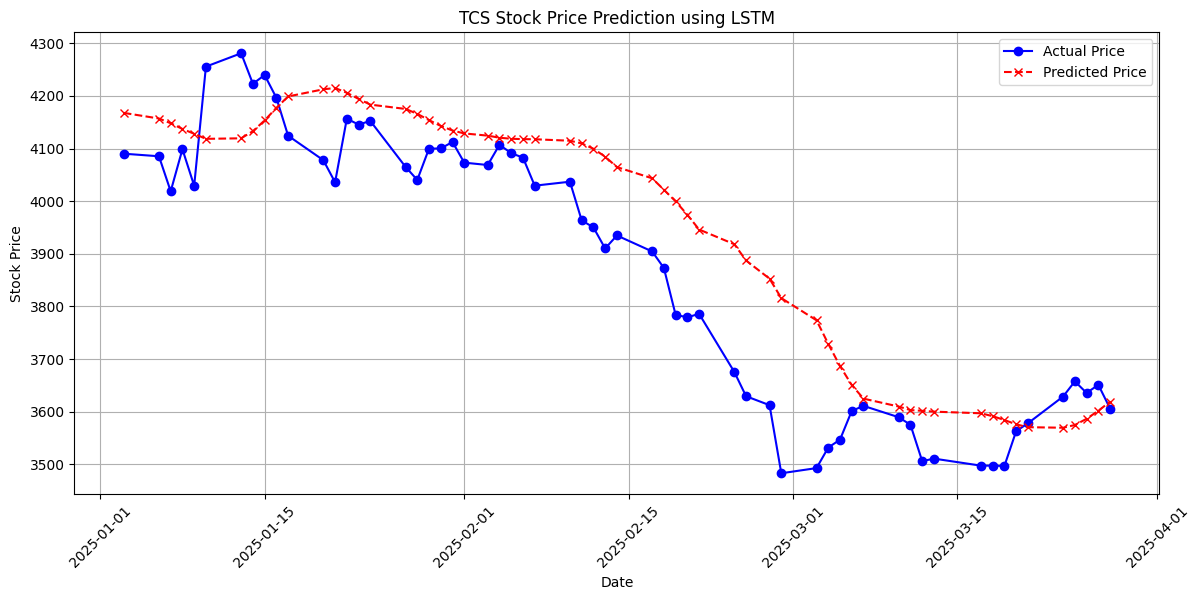

In [35]:
# Section 4: Predict and Plot Results

import matplotlib.pyplot as plt
import numpy as np

# Make predictions
predicted_prices = model.predict(X_test)

# Convert back to original scale
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1)).flatten()  # Fix reshaping

# Ensure test_dates are correctly formatted
test_dates = np.array(test_dates, dtype='datetime64[D]')  # Ensures daily timestamps only

# Adjust index to align predictions with actual test data
actual_prices = test_data.iloc[n_steps:]['Close'].values  # Extract corresponding actual prices

# Plot last 90 days of test data
plt.figure(figsize=(14, 6))
plt.plot(test_dates[-90:], actual_prices[-90:], label="Actual Price", color='blue', marker='o')
plt.plot(test_dates[-90:], predicted_prices[-90:], label="Predicted Price", color='red', linestyle='dashed', marker='x')
plt.title("TCS Stock Price Prediction using LSTM")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.xticks(rotation=45)  # Rotate for better visibility
plt.legend()
plt.grid()
plt.show()


**Use grid search to optimize hyperparameters such as ndrop , ntimestep and batch size.**

In [36]:
from sklearn.model_selection import ParameterGrid
import pandas as pd

# Define hyperparameter search space
param_grid = {
    'ndrop': [0.2, 0.3],        # Dropout rates
    'batch_size': [16, 32],      # Batch sizes
    'n_steps': [30, 60]          # Lookback window
}

best_loss = float('inf')
best_params = None
results = []  # Store results for analysis

for params in ParameterGrid(param_grid):
    print(f"Training with params: {params}")

    # Create sequences
    X_train, y_train, _ = create_sequences_with_dates(train_scaled, train_data.index, params['n_steps'])
    X_test, y_test, test_dates = create_sequences_with_dates(test_scaled, test_data.index, params['n_steps'])

    # Build and train model
    model = build_model(params['n_steps'], params['ndrop'])
    history = model.fit(X_train, y_train, epochs=50, batch_size=params['batch_size'], verbose=0, validation_split=0.1)

    # Evaluate model on test set
    loss = model.evaluate(X_test, y_test, verbose=0)

    # Store results
    results.append({'ndrop': params['ndrop'], 'batch_size': params['batch_size'], 'n_steps': params['n_steps'], 'loss': loss})

    # Track best parameters
    if loss < best_loss:
        best_loss = loss
        best_params = params

# Convert results to DataFrame and display
results_df = pd.DataFrame(results).sort_values(by="loss")
print("Hyperparameter Search Results:")
print(results_df)

print(f"\nBest Parameters: {best_params} with Loss: {best_loss:.4f}")


Training with params: {'batch_size': 16, 'n_steps': 30, 'ndrop': 0.2}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training with params: {'batch_size': 16, 'n_steps': 30, 'ndrop': 0.3}
Training with params: {'batch_size': 16, 'n_steps': 60, 'ndrop': 0.2}
Training with params: {'batch_size': 16, 'n_steps': 60, 'ndrop': 0.3}
Training with params: {'batch_size': 32, 'n_steps': 30, 'ndrop': 0.2}
Training with params: {'batch_size': 32, 'n_steps': 30, 'ndrop': 0.3}
Training with params: {'batch_size': 32, 'n_steps': 60, 'ndrop': 0.2}
Training with params: {'batch_size': 32, 'n_steps': 60, 'ndrop': 0.3}
Hyperparameter Search Results:
   ndrop  batch_size  n_steps      loss
3    0.3          16       60  0.000723
1    0.3          16       30  0.000843
2    0.2          16       60  0.000918
6    0.2          32       60  0.000965
0    0.2          16       30  0.001517
4    0.2          32       30  0.001531
7    0.3          32       60  0.002155
5    0.3          32       30  0.002760

Best Parameters: {'batch_size': 16, 'n_steps': 60, 'ndrop': 0.3} with Loss: 0.0007


**Train with best found model and plot**

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 0.0717
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.0078
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 0.0077
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0093
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.0066
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 0.0061
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0058
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0056
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 0.0048
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 0.0055
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0047
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0048
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.0050
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.0040
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: 0.0037
Epoch 16/

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


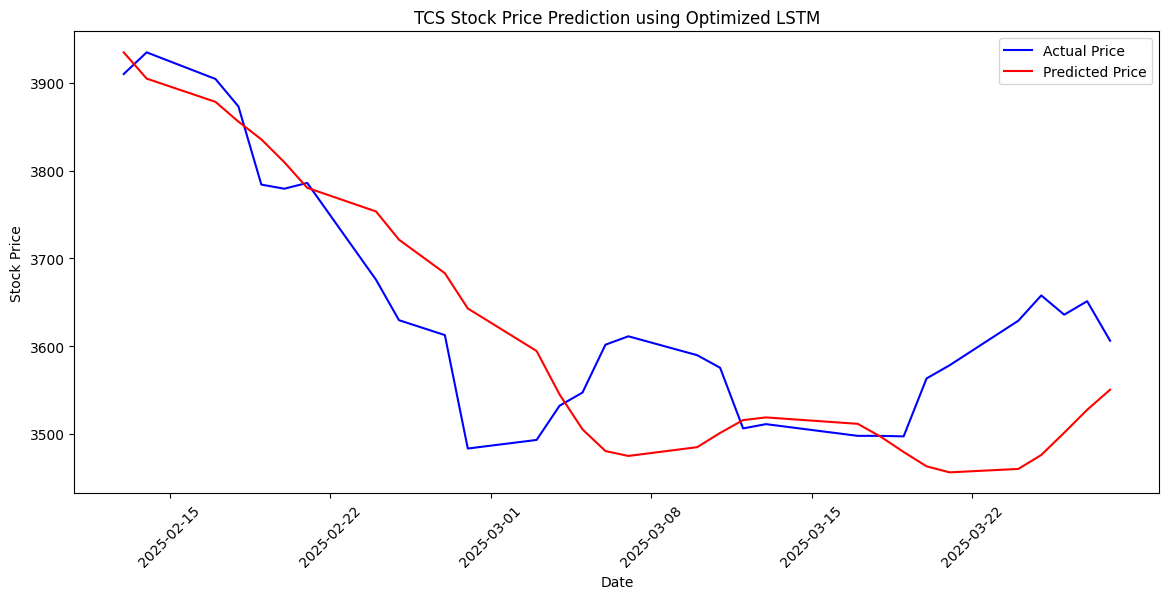

In [37]:
# --- Train the Final Model with Best Parameters ---
best_n_steps = best_params['n_steps']
best_ndrop = best_params['ndrop']
best_batch_size = best_params['batch_size']

X_train, y_train, _ = create_sequences_with_dates(train_scaled, train_data.index, best_n_steps)
X_test, y_test, test_dates = create_sequences_with_dates(test_scaled, test_data.index, best_n_steps)

# Build and train optimized LSTM model
best_model = build_model(best_n_steps, best_ndrop)
best_model.fit(X_train, y_train, epochs=50, batch_size=best_batch_size, verbose=1)

# Make predictions
predicted_prices = best_model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))  # Convert back to original scale

# Convert test_dates to correct format
test_dates = np.array(test_dates, dtype='datetime64[D]')

# --- Plot the Actual vs Predicted Prices ---
plt.figure(figsize=(14, 6))
plt.plot(test_dates, test_data.iloc[best_n_steps:]['Close'], label="Actual Price", color='blue')
plt.plot(test_dates, predicted_prices, label="Predicted Price", color='red')
plt.title("TCS Stock Price Prediction using Optimized LSTM")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.xticks(rotation=45)  # Rotate for better visibility
plt.legend()
plt.show()